# Aircraft Crashes Data Clustering

## Overview

This notebook explores different clustering algorithms and compares the different results. The data has already been cleaned in the [EDA phase](data_analysis.ipynb).

## Data Preprocessing

In [281]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import scipy.cluster.hierarchy as sch
from yellowbrick.cluster import KElbowVisualizer

In [282]:
# Load data
with open('data/crashes_cleaned_data.pkl', 'rb') as handle:
	df = pickle.load(handle)
df.head()

,date,category,type,operator,yom,engine,engine_model,flight_phase,flight_type,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
0,1970-01-02,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),Training,Airport (less than 10 km from airport),"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0
1,1970-01-03,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),Military,Airport (less than 10 km from airport),"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0
2,1970-01-05,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),Positioning,Airport (less than 10 km from airport),"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0
3,1970-01-05,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0
4,1970-01-10,Unknown,Beechcraft D18,Sherman Aircraft Sales,1946,Unknown,Unknown,Landing (descent or approach),Ferry,Airport (less than 10 km from airport),"Freeport, West Grand Bahama",Bahamas,Central America,26.541567,-78.770179,Unknown,1,0,0


In [283]:
# Split date in three columns
df.insert(0, 'year', df['date'].dt.year)
df.insert(1, 'month', df['date'].dt.month)
df.insert(2, 'day', df['date'].dt.day)
df = df.drop('date', axis=1)
df.head()

,year,month,day,category,type,operator,yom,engine,engine_model,flight_phase,...,site,location,country,region,latitude,longitude,aircraft_damage,occupants,fatalities,other_fatalities
0,1970,1,2,Accident,Lockheed 18 LodeStar,Sky King Inc.,1943,Multi Piston Engines,Unknown,Takeoff (climb),...,Airport (less than 10 km from airport),"North Little Rock-Municipal, Arkansas",United States of America,North America,34.832246,-92.259758,Destroyed,2,0,0
1,1970,1,3,Unknown,Fairchild C-123 Provider,United States Air Force - USAF (since 1947),1954,Unknown,Unknown,Landing (descent or approach),...,Airport (less than 10 km from airport),"Phan Rang, Ninh Thuận Province",Vietnam,Asia,11.576983,108.986539,Unknown,5,0,0
2,1970,1,5,Accident,Convair CV-990,Spantax,1962,Multi Jet Engines,General Electric CJ805-23,Takeoff (climb),...,Airport (less than 10 km from airport),"Stockholm-Arlanda, Uppland",Sweden,Europe,59.674971,14.520858,Destroyed,10,5,0
3,1970,1,5,Accident,Fokker F27 Friendship,Iberia - Lineas Aéreas de Espana,1968,Multi Turboprop Engines,Unknown,Landing (descent or approach),...,Airport (less than 10 km from airport),"La Palma (La Palma Island), Canary Islands",Spain,Europe,28.655116,-17.857269,Destroyed,49,0,0
4,1970,1,10,Unknown,Beechcraft D18,Sherman Aircraft Sales,1946,Unknown,Unknown,Landing (descent or approach),...,Airport (less than 10 km from airport),"Freeport, West Grand Bahama",Bahamas,Central America,26.541567,-78.770179,Unknown,1,0,0


### Reduce cardinality of string values

In [284]:
# Non-categorical columns
nb_unique = df.select_dtypes(include=['object']).nunique()
string_columns = nb_unique[nb_unique > 5].index
string_columns

Index(['type', 'operator', 'engine_model', 'flight_phase', 'flight_type',
       'site', 'location', 'country', 'region'],
      dtype='object')

In [285]:
for column in string_columns:
  values = list(df[column].value_counts().head(4).index)
  df[column] = np.where(df[column].isin(values), df[column], 'Other')

### Une Ordinal Encoding for category columns

In [287]:
cat_columns = df.select_dtypes(include=['category']).columns
ordinal_encoder = OrdinalEncoder()
encoded_cols = ordinal_encoder.fit_transform(df[cat_columns])
new_df = pd.DataFrame(encoded_cols, columns=ordinal_encoder.get_feature_names_out())
df = df.drop(columns=cat_columns, axis=1).join(new_df)

In [288]:
# Use One Hot Encoding for other columns
string_columns = df.select_dtypes(include=['object']).columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = onehot_encoder.fit_transform(df[string_columns])
new_df = pd.DataFrame(encoded_cols, columns=onehot_encoder.get_feature_names_out())
df = df.drop(columns=string_columns, axis=1).join(new_df)

In [289]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [290]:
# Export data
df.to_csv('data/crashes_preprocessed_data.csv', index=False)

## Feature Engineering

In [291]:
df.shape

(12980, 48)

In [292]:
X = df.copy()

In [293]:
# Use PCA to reduce dimensionality to half
pca = PCA(n_components=24, whiten=True, random_state=42)
X_pca = pca.fit_transform(X)

In [294]:
X_pca = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23
0,-0.834860,0.460449,-0.174488,-0.145333,0.423188,-1.381051,-1.601642,0.226200,-1.607148,-1.173928,...,0.671942,-1.059021,-0.210141,-0.108452,-0.939206,-0.727454,-0.365618,-0.487971,-1.228822,0.069730
1,1.563512,0.342608,-0.618666,0.196500,0.428269,-1.412756,-1.531900,0.059986,-1.570067,1.439542,...,1.372875,-0.418761,-0.648184,-0.503913,-0.078695,-0.310265,0.296595,-0.460825,1.038414,-1.265681
2,0.418288,0.180360,-0.187670,-1.425352,0.475697,-1.232554,-1.291915,0.227605,-1.636562,-1.067181,...,0.673101,-2.034389,-0.675391,0.929989,1.443646,-0.876766,0.490406,0.294956,0.399467,-0.702330
3,0.100847,0.047622,0.740493,-0.094753,-0.720334,-1.960890,-1.264335,0.202945,-1.623276,-0.622236,...,-0.439797,0.301755,-0.722961,0.509774,-0.489959,-1.383737,-0.790545,-0.568978,-1.824754,0.780340
4,-0.669498,0.415578,-0.242151,0.140292,0.473610,-1.410734,-0.698891,0.128941,-1.584415,0.963786,...,1.089380,-0.785718,1.258315,-1.364235,0.071709,-0.065563,0.099524,-0.207393,0.119071,-1.618204


In [295]:
# Export data
X_pca.to_csv('data/pca_preprocessed_data.csv', index=False)

## Data Modeling

### K-Means

#### Find clusters

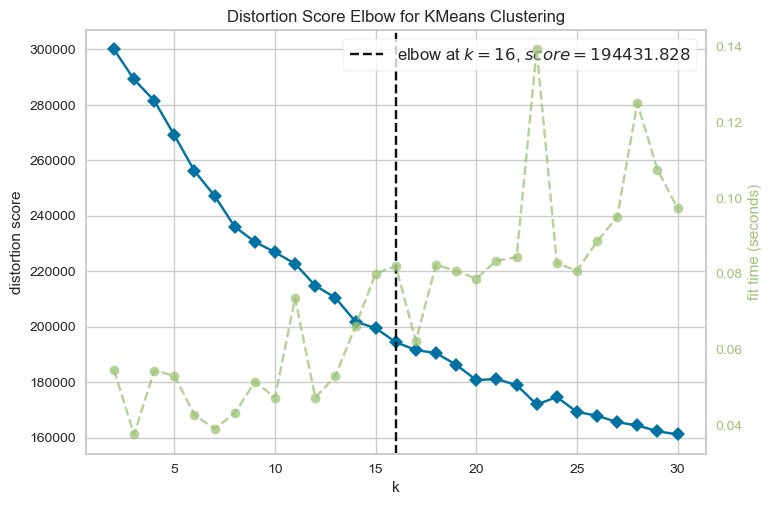

In [301]:
# SSD plot
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=30)
visualizer.fit(X_pca)
visualizer.show();

In [297]:
# Create multiple models for silhouette score
k_values = []
scores = []
for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    kmeans.fit(X_pca)
    k_values.append(k)
    scores.append(silhouette_score(X_pca, kmeans.labels_, metric='euclidean'))

models = pd.Series(data=scores, index=k_values)

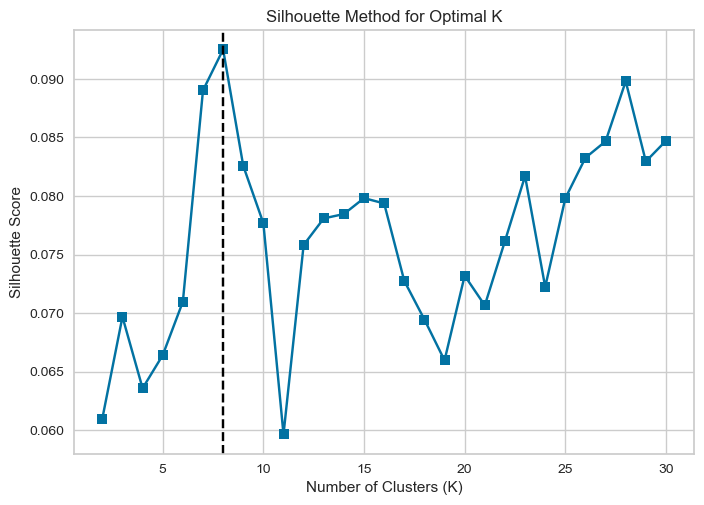

In [300]:
# Silhouette score plot
plt.plot(models, marker='s')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal K')
plt.axvline(x=models.idxmax(), color='black', linestyle='--')
plt.show()

In [299]:
models.nlargest(n=5)

8     0.092514
28    0.089799
7     0.089019
30    0.084719
27    0.084675
dtype: float64

In [302]:
# Based on the elbow and silhouette methods, a good k value vould be 8
kmeans = KMeans(n_clusters=8, random_state=42)
kmeans.fit(X)

KMeans(random_state=42)

In [303]:
original_df = pd.read_csv('data/crashes_cleaned_data.csv', parse_dates=['date'])
original_df.insert(0, 'year', original_df['date'].dt.year)
original_df.insert(1, 'month', original_df['date'].dt.month)
original_df.insert(2, 'day', original_df['date'].dt.day)
original_df.insert(0, 'cluster_1', kmeans.labels_)
original_df = original_df.drop('date', axis=1)

#### Analyse the clusters

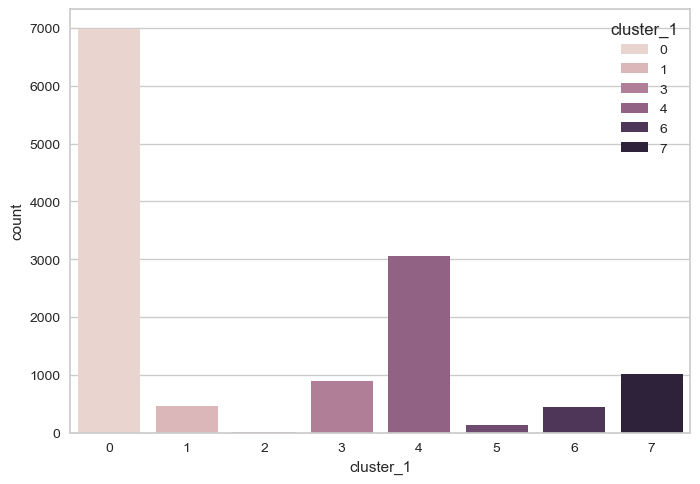

In [304]:
sns.countplot(data=original_df, x='cluster_1', hue='cluster_1');

In [ ]:
cluster0 = original_df[original_df['cluster_1'] == 0]

In [306]:
cluster0.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,6979.0,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000,6979.000000
mean,0.0,1992.428715,6.612695,15.713999,1970.872475,28.484414,-91.966305,6.882935,3.146153,0.080671
std,0.0,14.925857,3.496715,8.827924,15.316039,23.129515,24.735963,14.184083,7.753095,1.765469
min,0.0,1970.000000,1.000000,1.000000,1927.000000,-54.935761,-179.491343,0.000000,0.000000,0.000000
25%,0.0,1979.000000,4.000000,8.000000,1960.000000,18.292201,-104.938594,2.000000,0.000000,0.000000
50%,0.0,1990.000000,7.000000,16.000000,1972.000000,34.729847,-87.844794,3.000000,1.000000,0.000000
75%,0.0,2004.000000,10.000000,23.000000,1980.000000,41.466983,-74.970637,6.000000,3.000000,0.000000
max,0.0,2025.000000,12.000000,31.000000,2023.000000,79.990159,-37.116877,159.000000,111.000000,110.000000


In [307]:
cluster0.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,6979,6979,6979,6979,6979,6979,6979,6979,6979,6979,6979,6979
unique,5,381,4559,7,510,6,31,7,4060,58,8,7
top,Unknown,Piper PA-31-310 Navajo,Private American,Unknown,Unknown,Landing (descent or approach),Private,Airport (less than 10 km from airport),"Bogotá-El Dorado, Bogotá Capital District",United States of America,North America,Unknown
freq,3891,202,128,4167,4825,3119,1360,3903,34,4024,4642,3858


In [309]:
cluster1 = original_df[original_df['cluster_1'] == 1]

In [310]:
cluster1.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,460.0,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,1.0,1995.300000,6.630435,15.723913,1981.293478,29.406805,43.569115,130.389130,34.502174,0.508696
std,0.0,14.991254,3.633892,8.934272,13.676418,20.892774,53.588643,52.416452,43.973328,4.739618
min,1.0,1970.000000,1.000000,1.000000,1944.000000,-34.996496,-122.689214,57.000000,0.000000,0.000000
25%,1.0,1982.000000,3.000000,8.000000,1971.000000,15.353352,12.500075,94.750000,0.000000,0.000000
50%,1.0,1995.000000,7.000000,16.000000,1980.000000,33.602853,41.281981,117.000000,1.500000,0.000000
75%,1.0,2008.000000,10.000000,23.000000,1991.000000,43.272686,79.530928,154.000000,75.000000,0.000000
max,1.0,2025.000000,12.000000,31.000000,2021.000000,69.371821,144.757709,395.000000,141.000000,78.000000


In [311]:
cluster1.select_dtypes(include=['object']).describe()

,category,type,operator,engine,engine_model,flight_phase,flight_type,site,location,country,region,aircraft_damage
count,460,460,460,460,460,460,460,460,460,460,460,460
unique,3,75,227,4,153,5,7,6,352,100,6,4
top,Accident,Boeing 737-200,Aeroflot - Russian International Airlines,Multi Jet Engines,Unknown,Landing (descent or approach),Scheduled Revenue Flight,Airport (less than 10 km from airport),"Tehran-Mehrabad, Tehran City District",Russia,Asia,Destroyed
freq,424,49,60,395,57,311,394,360,6,56,272,349


In [313]:
cluster2 = original_df[original_df['cluster_1'] == 2]

In [314]:
cluster2.describe()

,cluster_1,year,month,day,yom,latitude,longitude,occupants,fatalities,other_fatalities
count,12.0,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,2.0,1987.750000,4.750000,17.250000,35.583333,36.275919,31.072586,4.750000,0.916667,0.0
std,0.0,20.494456,2.832442,11.038157,69.757317,30.833558,67.699322,8.400487,1.311372,0.0
min,2.0,1970.000000,1.000000,2.000000,0.000000,-41.500083,-81.759616,0.000000,0.000000,0.0
25%,2.0,1970.750000,2.750000,9.750000,2.000000,23.055746,6.240193,0.750000,0.000000,0.0
50%,2.0,1978.000000,4.000000,17.500000,20.500000,49.725144,35.908132,2.000000,0.000000,0.0
75%,2.0,2014.000000,7.000000,28.250000,27.500000,54.651421,53.995691,2.500000,2.000000,0.0
max,2.0,2016.000000,10.000000,31.000000,254.000000,64.686314,172.834408,29.000000,4.000000,0.0


##### Observations

0. Accidents in the western hemisphere, mostly in the US, near an airport, in smaller planes
1. Accidents in bigger commercial planes
2.
3.
4.
5.
6.
7.
8.

### Hierarchical Clustering

In [ ]:
# Plot dendogram for optimal cluster determination
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.hlines(y=190,xmin=0,xmax=2000,lw=3,linestyles='--')
plt.text(x=900,y=220,s='Horizontal line crossing 5 vertical lines',fontsize=20)
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

In [ ]:
# Model
ac = AgglomerativeClustering(n_clusters= 5, metric='euclidean', linkage='ward')
ac.fit(X)

In [ ]:
original_df['Cluster'] = ac.labels_

#### Analyse clusters

bla bla bla

### DBSCAN

In [ ]:
models = []
min_samples = 2 * len(scaled_X.columns)

for eps in np.linspace(0.001, 3, 50):
	dbscan = DBSCAN(eps=eps, min_samples=min_samples)
	dbscan.fit(scaled_X)

	unique, counts = np.unique(dbscan.labels_, return_counts=True)
	freqs = dict(zip(unique, counts))

	percentage = freqs[-1] / len(scaled_X)
	
	models.append({'epsilon': eps, 'outliers': percentage})

models_df = pd.DataFrame(models)

In [ ]:
# Outlier points vs. eps value lineplot
sns.lineplot(data=models_df, x='epsilon', y='outliers');

In [ ]:
# DBSCAN with chosen epsilon value
model = DBSCAN(eps=2, min_samples=min_samples)
model.fit(scaled_X)

In [ ]:
# Add cluster to dataframe
original_df['Cluster'] = model.labels_

#### Analyse clusters

bla bla bla

### Compare the different clusterings

bla bla bla

## End